In [49]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import log_loss

dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

D, N = X.shape[0], X.shape[1] + 1


In [50]:
class Node:
  def __init__(self, curr_pred, feature_index, threshold, depth, num_samples, left=None, right=None):
    self.curr_pred = curr_pred
    self.left = left
    self.right = right
    self.threshold = threshold
    self.feature_index = feature_index
    self.depth = depth
    self.num_samples = num_samples

In [51]:
def ans(X_m, y_m):
  n_samples = len(y_m)
  epsilon = 1e-9

  p1 = np.sum(y_m) / n_samples
  p1 = np.clip(p1, epsilon, 1 - epsilon)

  p0 = 1 - p1
  return p0, p1


In [52]:
import numpy as np

def H(X_m, y_m):
  p0, p1= ans(X_m, y_m)
  losses = -y_m * np.log(p1) - (1 - y_m) * np.log(p0)
  return np.mean(losses)

In [53]:
def branch(X_m, y_m, j, t):
  left_mask = X_m[:, j] <= t
  right_mask = X_m[:, j] > t

  if left_mask.sum() == 0 or right_mask.sum() == 0:
    return 0

  X_l, y_l = X_m[left_mask], y_m[left_mask]
  X_r, y_r = X_m[right_mask], y_m[right_mask]

  H_parent = H(X_m, y_m)
  H_left = H(X_l, y_l)
  H_right = H(X_r, y_r)

  branch = len(X_m) * H_parent - len(X_l) * H_left - len(X_r) * H_right

  return branch


In [54]:
def stop(X_m, y_m, depth, max_depth, min_samples_split):
  if depth >= max_depth:
    return True
  if len(y_m) < min_samples_split:
    return True
  if len(np.unique(y_m)) == 1:
    return True

  return False


In [55]:
max_depth = 3
min_samples_split = 5
min_gain = 1e-6
def build_tree(X_m, y_m, depth):
    p0, p1 = ans(X_m, y_m)

    if stop(X_m, y_m, depth, max_depth, min_samples_split):
      return Node(p1, None, None, depth, len(y_m))

    best_gain = 0
    best_j = None
    best_t = None

    n_features = X_m.shape[1]

    # search best split
    for j in range(n_features):
        values = np.unique(X_m[:, j])
        thresholds = (values[:-1] + values[1:]) / 2

        for t in thresholds:
            gain = branch(X_m, y_m, j, t)

            if gain > best_gain:
                best_gain = gain
                best_j = j
                best_t = t

    # if no improvement → leaf
    if best_gain < min_gain:
        return Node(curr_pred=p1,
                    feature_index=None,
                    threshold=None,
                    depth=depth,
                    num_samples=len(y_m))


    # split
    left_mask = X_m[:, best_j] <= best_t
    right_mask = X_m[:, best_j] > best_t

    X_l, y_l = X_m[left_mask], y_m[left_mask]
    X_r, y_r = X_m[right_mask], y_m[right_mask]

    # safe split
    if len(y_l) == 0 or len(y_r) == 0:
      return Node(p1, None, None, depth, len(y_m))

    left_child = build_tree(X_l, y_l, depth + 1)
    right_child = build_tree(X_r, y_r, depth + 1)

    return Node(curr_pred=p1,
                feature_index=best_j,
                threshold=best_t,
                depth=depth,
                num_samples=len(y_m),
                left=left_child,
                right=right_child)



In [56]:
tree = build_tree(X, y, depth=0)

In [57]:
def predict_one(node, x):
  while node.left is not None and node.right is not None:
    if x[node.feature_index] <= node.threshold:
      node = node.left
    else:
      node = node.right

  return node.curr_pred

def predict_proba(tree, X):
  return np.array([predict_one(tree, x) for x in X])

y_pred = predict_proba(tree, X)
loss = log_loss(y, y_pred)
loss

0.0851704565529309

In [58]:
X_2d = X[:, :2]
max_depth = 3
tree_2d = build_tree(X_2d, y, depth=0)


In [59]:
import matplotlib.pyplot as plt

x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid = np.c_[xx.ravel(), yy.ravel()]
Z = predict_proba(tree_2d, grid)
Z = Z.reshape(xx.shape)


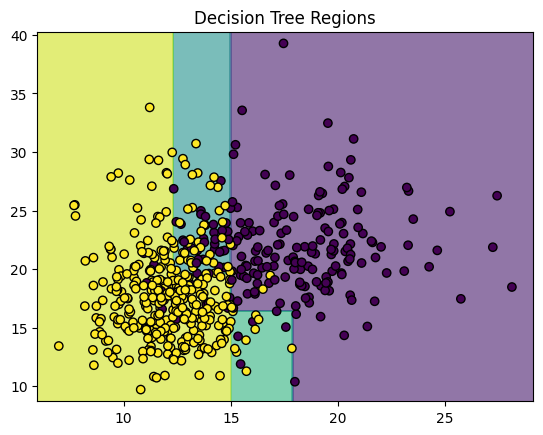

In [60]:
plt.contourf(xx, yy, Z, alpha=0.6)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor='k')
plt.title("Decision Tree Regions")
plt.show()
